In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, BatchNormalization, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, plot_model

In [2]:
classes = 7
image_path = 'images'

train_dir = f'{image_path}/train/'
test_dir = f'{image_path}/test/'

In [3]:
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_dir,'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<AxesSubplot:>

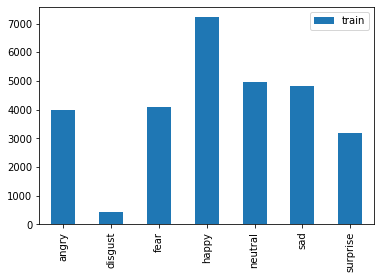

In [4]:
train_count.transpose().plot(kind='bar')

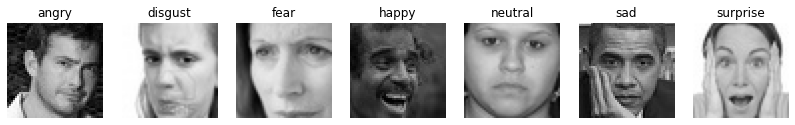

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,classes,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, horizontal_flip=True) 

training_set = train_datagen.flow_from_directory(train_dir,
                                                 batch_size=64,
                                                 target_size=(48,48),
                                                 shuffle=False,
                                                 color_mode='grayscale',
                                                 class_mode='categorical'
                                                )
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir, 
                                            batch_size=64, 
                                            target_size=(48,48),
                                            shuffle=False,
                                            color_mode='grayscale',
                                            class_mode='categorical'
                                           )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [8]:
def get_model(input_size, classes):
    #initializing the CNN
    model = tf.keras.models.Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [9]:
primary_emotion_set = get_model((48, 48, 1), classes)
primary_emotion_set.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


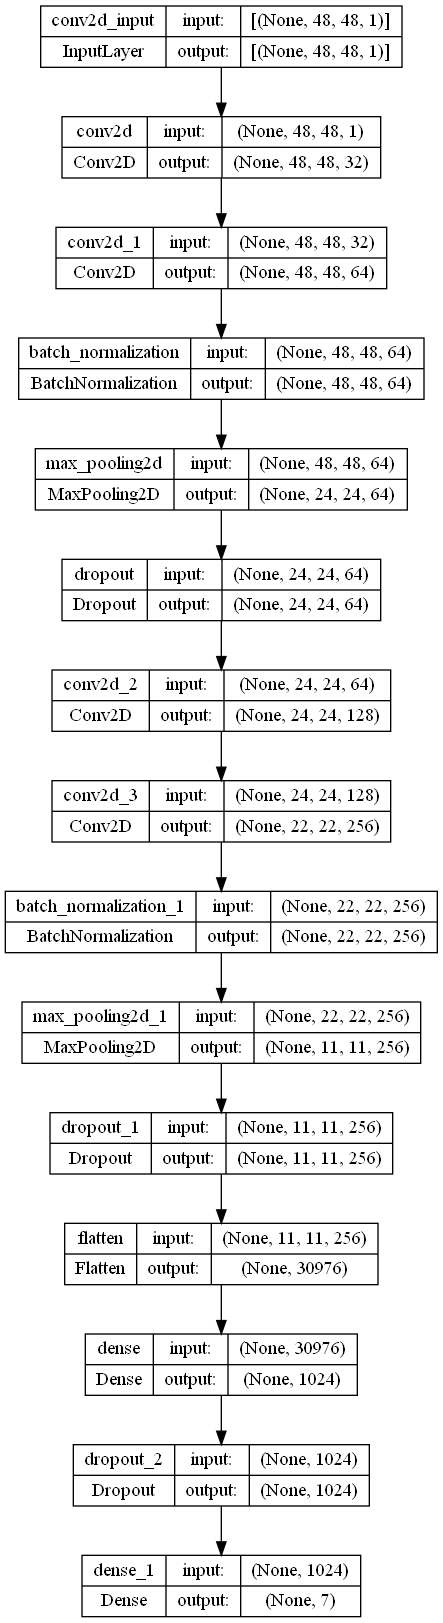

In [10]:
plot_model(primary_emotion_set, to_file='primary_emotion_set.png', show_shapes=True, show_layer_names=True)

In [11]:
chk_path = 'primary_emotion_set.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [12]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = primary_emotion_set.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.7703 - accuracy: 0.2115
Epoch 1: val_loss improved from inf to 8.18622, saving model to primary_emotion_set.h5
448/448 [==============================] - 22s 43ms/step - loss: 4.7703 - accuracy: 0.2115 - val_loss: 8.1862 - val_accuracy: 0.1982 - lr: 1.0000e-04
Epoch 2/60
447/448 [============================>.] - ETA: 0s - loss: 3.7341 - accuracy: 0.2753
Epoch 2: val_loss improved from 8.18622 to 3.41949, saving model to primary_emotion_set.h5
448/448 [==============================] - 16s 36ms/step - loss: 3.7336 - accuracy: 0.2750 - val_loss: 3.4195 - val_accuracy: 0.3274 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 3.2430 - accuracy: 0.2999
Epoch 3: val_loss improved from 3.41949 to 2.93648, saving model to primary_emotion_set.h5
448/448 [==============================] - 16s 36ms/step - loss: 3.2430 - accuracy: 0.2999 - val_loss: 2.9365 - val_accuracy: 0.3551 - lr: 1.00

# Loss & accuracy

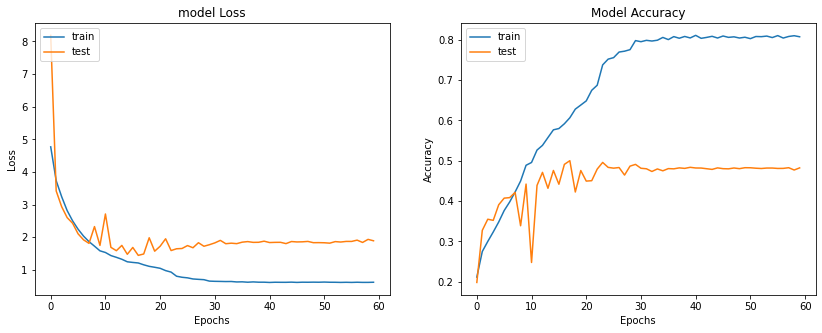

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test

In [17]:
train_loss, train_accu = primary_emotion_set.evaluate(training_set)
test_loss, test_accu = primary_emotion_set.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 2s 16ms/step - loss: 1.8956 - accuracy: 0.4819
final train accuracy = 54.74 , validation accuracy = 48.19


# Save weights

In [18]:
primary_emotion_set.save_weights('primary_emotion_bestweight.h5')

# Confusion matrix

449/449 [==============================] - 14s 31ms/step
Confusion Matrix
[[2565   10  383  225  724   88    0]
 [ 166  140   37   17   60   15    1]
 [ 605   10 2144  246  887  203    2]
 [ 320    1  299 5803  696   93    3]
 [ 292    1  342  327 3906   97    0]
 [ 684    7  976  414 1596 1152    1]
 [ 321    3 1916  328  508   63   32]]
Classification Report
              precision    recall  f1-score   support

       angry       0.52      0.64      0.57      3995
     disgust       0.81      0.32      0.46       436
        fear       0.35      0.52      0.42      4097
       happy       0.79      0.80      0.80      7215
     neutral       0.47      0.79      0.59      4965
         sad       0.67      0.24      0.35      4830
    surprise       0.82      0.01      0.02      3171

    accuracy                           0.55     28709
   macro avg       0.63      0.48      0.46     28709
weighted avg       0.62      0.55      0.51     28709



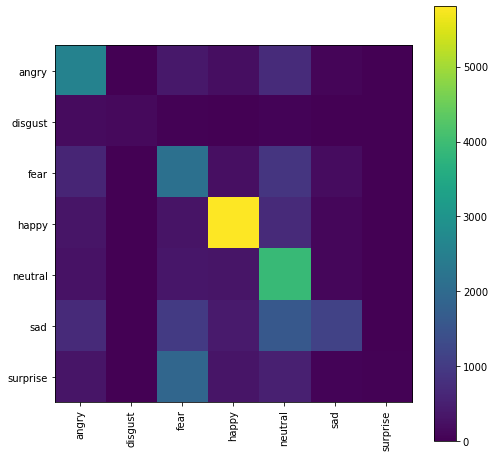

In [20]:
y_pred = primary_emotion_set.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# Confusion matrix on test set

113/113 [==============================] - 2s 17ms/step
Confusion Matrix
[[ 523    7  106   60  213   49    0]
 [  45   31    8    3   18    6    0]
 [ 170    1  415   61  296   81    0]
 [ 103    3   78 1308  245   37    0]
 [  71    2   79   88  930   61    2]
 [ 166    3  212  109  517  240    0]
 [  95    1  504   65  133   21   12]]
Classification Report
              precision    recall  f1-score   support

       angry       0.45      0.55      0.49       958
     disgust       0.65      0.28      0.39       111
        fear       0.30      0.41      0.34      1024
       happy       0.77      0.74      0.75      1774
     neutral       0.40      0.75      0.52      1233
         sad       0.48      0.19      0.28      1247
    surprise       0.86      0.01      0.03       831

    accuracy                           0.48      7178
   macro avg       0.56      0.42      0.40      7178
weighted avg       0.55      0.48      0.45      7178



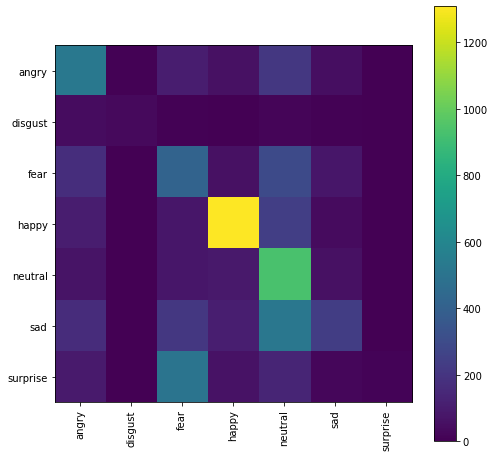

In [21]:
y_pred = primary_emotion_set.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# --------------------------------------------------------------------------------
# Load weights

In [ ]:
# primary_emotion_set.load_weights('../backup/tiny_emotion-v6/primary_emotion_bestweight.h5')

# train_loss, train_accu = primary_emotion_set.evaluate(training_set)
# test_loss, test_accu = primary_emotion_set.evaluate(test_set)
# print("final train accuracy = {:.2f}".format(train_accu*100))
# print("final test accuracy = {:.2f}".format(test_accu*100))

# Custom images

In [ ]:
# custom_dir = 'custom/'
# custom_dir = 'custom_color/'
# custom_dir = test_dir

## Custom images dataset

In [ ]:
# custom_datagen = ImageDataGenerator(rescale=1./84)
# custom_set = custom_datagen.flow_from_directory(custom_dir,
#                                                 batch_size=64,
#                                                 target_size=(48, 48),
#                                                 shuffle=False,
#                                                 color_mode='grayscale',
#                                                 class_mode='categorical'
#                                                 )

# custom_loss, custom_accu = primary_emotion_set.evaluate(custom_set)
# print("final custom accuracy = {:.2f}, custom loss = {:.2f}".format(custom_accu*100, custom_loss*100))

# custom_prediction = primary_emotion_set.predict(custom_set)
# print(custom_prediction)

## Custom images (no dataset)

### Useful functions

In [ ]:
# label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Joy', 4: 'Sad', 5: 'Surprise'}

# def load(img_path):
#    np_image = tf.keras.utils.load_img(
#        f"{img_path}", target_size=(48, 48), color_mode='grayscale')
#    np_image = np.array(np_image).astype('float32')/255
#    # makes image shape (48,48, X) => (1, 48,48, X) [X = 1 if grayscale, 3 if RGB]
#    np_image = np.expand_dims(np_image, axis=0)
#    return np_image

# def predict(img_path, model):
#     img = load(img_path)
#     result_guess = model.predict(img, verbose=0)
#     result_guess = list(result_guess[0])

#     img_index = result_guess.index(max(result_guess))
#     return label_dict[img_index], result_guess

### Recursive image scanning and prediction

In [ ]:
# from pathlib import Path

# debug=False

# paths = list(Path(f'{custom_dir}').rglob("*.[pj][np][g]"))

# emotionRes = {label_dict[key].lower(): {'right': 0, 'wrong': 0} for key in label_dict.keys()}
# lastEmotion = None

# for pathw in paths:
#     path = str(pathw)
#     emotion = path.split('\\')[path.count('\\') - 1].lower()
#     if debug and (lastEmotion == None or emotion != lastEmotion):
#         lastEmotion = emotion
#         print(f"\n{emotion}")

#     label_guess, result_guess = predict(path, primary_emotion_set)
    
#     if debug:
#         print(" »", label_guess, result_guess)

#     if label_guess.lower() == emotion:
#         emotionRes[emotion]['right'] += 1
#     else:
#         emotionRes[emotion]['wrong'] += 1

# print("\nEnd")

### Resultats output

In [ ]:
# right = sum(d['right'] for d in emotionRes.values())
# wrong = sum(d['wrong'] for d in emotionRes.values())
# total = right + wrong

# for emotion in emotionRes:
#     emoRight = emotionRes[emotion]['right']
#     emoWrong = emotionRes[emotion]['wrong']
#     emoTotal = emoRight + emoWrong
#     accuracy = emoRight/(1 if emoTotal == 0 else emoTotal)*100

#     print(f"{emotion.ljust(10)}: right: {str(emoRight).ljust(3)} | wrong: {str(emoWrong).ljust(3)} | accuracy: {accuracy:.2f}%")

# print(f"\nGot {str(right)} right and {str(wrong)} wrong,", f"accuracy: {right/(1 if total == 0 else total)*100:.2f}%")